In [39]:
import pandas as pd
from pandas import set_option
from pandas import DataFrame
import tensorflow as tf

import numpy as np

from tensorflow import keras

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from pickle import dump
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [40]:
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


In [41]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

In [42]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [43]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [44]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1235, 556)


In [45]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    #X = np.array(X)    
    #y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b= best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

/home/haziqfaiz/lib64/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 14 507 508 514 531] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/haziqfaiz/lib64/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/haziqfaiz/lib64/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


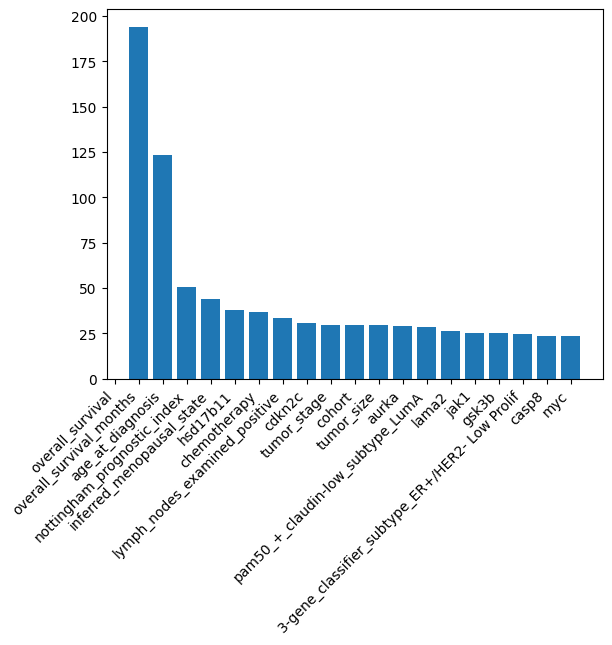

In [46]:
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']
X, y, fs = select_features(X, y, 20)

In [47]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X = DataFrame(X)

print(X.shape)

(1235, 20)


In [48]:
y= DataFrame(y)
y

,death_from_cancer
1,0.0
2,2.0
3,0.0
4,2.0
5,2.0
...,...
1619,0.0
1621,1.0
1623,0.0
1628,2.0


In [49]:
def my_model_1():
    return tf.keras.Sequential(
        [
            keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(1, activation='softplus') 
        
        ]
    )

In [51]:
fold_no=1
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
for kfold, (train, test) in enumerate(KFold(n_splits=3, 
                                shuffle=True).split(X, y)):
    # clear the session 
    tf.keras.backend.clear_session()

    # calling the model and compile it 
    seq_model = my_model_1()
    seq_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])
    
    #print('Train Set')
    #print(X.iloc[train].shape)
    #print(y.iloc[train].shape)

    #print('Test Set')
    #print(X.iloc[test].shape)
    #print(y.iloc[test].shape)

    # run the model 
    seq_model.fit(X.iloc[train], y.iloc[train],
              batch_size=64, epochs=2, validation_data=(X.iloc[test], y.iloc[test]))
    seq_model.save_weights(f'wg_{kfold}.h5')
    
    # Generate generalization metrics
    scores = seq_model.evaluate(X.iloc[test], y.iloc[test])
    print(f'Score for fold {fold_no}: {seq_model.metrics_names[0]} of {scores[0]}; {seq_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/2
13/13 [==============================] - 1s 16ms/step - loss: 0.2152 - mse: 0.7505 - val_loss: 0.1752 - val_mse: 0.6270
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1216 - mse: 0.4349
Score for fold 1: loss of 0.12158264964818954; mse of 43.49298179149628%
Epoch 1/2
13/13 [==============================] - 1s 20ms/step - loss: 0.2316 - mse: 0.8273 - val_loss: 0.1893 - val_mse: 0.6556
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1297 - mse: 0.4377
Score for fold 2: loss of 0.12971268594264984; mse of 43.770429491996765%
Epoch 1/2
13/13 [==============================] - 1s 18ms/step - loss: 0.2068 - mse: 0.7290 - val_loss: 0.1723 - val_mse: 0.6270
Epoch 2/2
13/13 [==============================] - 0s 2ms/step - loss: 0.1220 - mse: 0.4318
Score for fold 3: loss of 0.12196359038352966; mse of 43.1836873292923%
